# mocsy examples using mocsy from IOOS channel
11/9/2015. [Emilio Mayorga](https://github.com/emiliom). Reproduce and extend Examples 1-3 from the mocys Python documentation page.
- mocsy Python source documentation: http://ocmip5.ipsl.jussieu.fr/mocsy/pyth.html
- See ioos-channel implementation discussions at https://github.com/ioos/conda-recipes/pull/563
- Include brief text describing how to add the IOOS channel and create a bare minimum conda env with mocsy (and pandas, etc)?

In [1]:
import mocsy

## Example 1, Simple scalar variables
Functions return 1-dimensional numpy arrays. Scalar inputs return length-1 arrays.

For DATA input: DIC and ALk in mol/kg, in situ temperature, pressure.

In [2]:
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = \
    mocsy.mvars(temp=18, sal=35, alk=2300.e-6, dic=2000.e-6, sil=0, phos=0, 
                patm=1, depth=100, lat=0, 
                optcon='mol/kg', optt='Tinsitu', optp='db', 
                optb="u74", optk1k2='l', optkf="dg", optgas='Pinsitu')
print(pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis)

(array([ 8.14892578], dtype=float32), array([ 312.28662109], dtype=float32), array([ 300.68057251], dtype=float32), array([  1.01729711e-05], dtype=float32), array([ 0.00177952], dtype=float32), array([ 0.00021031], dtype=float32), array([ 3.19940853], dtype=float32), array([ 4.94189167], dtype=float32), array([ 9.68977737], dtype=float32), array([ 1025.71105957], dtype=float32), array([ 100.], dtype=float32), array([ 18.], dtype=float32))


Compute the CONSTANTS with the same scalar input for S, T, and P (as above) but change to the newer options published since the best-practices guide: Lee et al. (2010) for total boron and Millero (2010) for K<sub>1</sub> and K<sub>2</sub>:

In [3]:
Kh,K1,K2,Kb,Kw,Ks,Kf,Kspc,Kspa,K1p,K2p,K3p,Ksi,St,Ft,Bt = \
    mocsy.mconstants(temp=18, sal=35, patm=1, depth=0,lat=0, 
                     optt='Tinsitu', optp='m', 
                     optb="l10", optk1k2='m10', optkf="dg", optgas='Ppot')
print(Kh,K1,K2,Kb,Kw,Ks,Kf,Kspc,Kspa,K1p,K2p,K3p,Ksi,St,Ft,Bt)

(array([ 0.03428761]), array([  1.21367294e-06]), array([  8.28929483e-10]), array([  2.08897987e-09]), array([  3.16159683e-14]), array([ 0.13032609]), array([ 0.00327175]), array([  4.30745611e-07]), array([  6.66111159e-07]), array([ 0.02471062]), array([  9.60420732e-07]), array([  1.11966778e-09]), array([  3.10671746e-10]), array([ 0.02823543]), array([  6.83244011e-05]), array([ 0.0004326]))


For MODEL input: DIC and Alk in mol/m3, potential temperature, and depth. Also do NOT specify last 4 options, thus using defaults (optb='l10', optk1k2='l', optkf='pf', optgas='Pinsitu').

In [4]:
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = \
    mocsy.mvars(temp=18, sal=35, alk=2300*1028e-6, dic=2000*1028e-6, sil=0, phos=0,
                patm=1, depth=100, lat=0, 
                optcon='mol/m3', optt='Tpot', optp='m')
print(pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis)

(array([ 8.14304447], dtype=float32), array([ 317.7567749], dtype=float32), array([ 305.88537598], dtype=float32), array([ 0.01060902], dtype=float32), array([ 1.83167541], dtype=float32), array([ 0.21371585], dtype=float32), array([ 3.16961932], dtype=float32), array([ 4.89563847], dtype=float32), array([ 9.65654659], dtype=float32), array([ 1025.70947266], dtype=float32), array([ 100.61317444], dtype=float32), array([ 18.01725388], dtype=float32))


## Example 2,  Simple arrays (numpy)
Also demonstrate import into Pandas DataFrame and plotting.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
# Make dummy array with 11 members
one = np.ones(11, dtype='float32')

sal   = 35*one
temp  = 2*one
patm  = 1*one
depth = np.arange(0,11000,1000, dtype='float32')  # units in 'm'

In [7]:
# Compute in situ density (3 steps using 2 mocsy routines):
# a) Specify latitude = 60°S for depth to pressure conversion formula
lat = -60*one
# b) Compute pressure (db) from depth (m) and latitude following Saunders (1981)
pfd = mocsy.mdepth2press(depth,lat)  # units in 'db' 
# c) Compute in situ density (kg/m3) from salinity (psu), in-situ temp (C), and pressure (db)
rhois = mocsy.mrhoinsitu(sal, temp, pfd)

In [8]:
# Specify surface concentrations typical of 60°S (from GLODAP and WOA2009)
alk   = 2295*one # umol/kg
dic   = 2154*one # umol/kg
sio2  = 50.*one  # umol/L
po4   = 1.8*one  # umol/L

In [9]:
# Convert nutrient units(mol/L) to model units (mol/m3)
sio2 = sio2 * 1.0e-3   
po4  = po4  * 1.0e-3 
# Convert Alk and DIC units (umol/kg) to model units (mol/m3)
dic = dic * rhois * 1e-6
alk = alk * rhois * 1e-6

In [10]:
# Compute carbonate system variables, using 'model' options.
# Note that original example code had an error: 
# patm argument was passed as scalar rather than array shaped like one
response_tup = mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, 
                           sil=sio2, phos=po4, patm=patm, depth=depth, lat=lat, 
                           optcon='mol/m3', optt='Tpot', optp='m')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

In [11]:
depth, pH, OmegaA

(array([     0.,   1000.,   2000.,   3000.,   4000.,   5000.,   6000.,
          7000.,   8000.,   9000.,  10000.], dtype=float32),
 array([ 8.05916595,  8.01757812,  7.97552681,  7.93305302,  7.89020014,
         7.84701252,  7.8035388 ,  7.75982523,  7.71591997,  7.67187119,
         7.62772655], dtype=float32),
 array([ 1.55457842,  1.25153887,  1.01237512,  0.82299215,  0.67249018,
         0.55242962,  0.45627609,  0.37894735,  0.31649008,  0.26582268,
         0.22453403], dtype=float32))

### Import into Pandas DataFrame

In [12]:
data_for_pd = dict(depth=depth, 
                   temp=temp, sal=sal, alk=alk, dic=dic, sil=sio2, phos=po4,
                   pH=pH, pCO2=pco2, fCO2=fco2, CO3=co3, OmegaA=OmegaA, OmegaC=OmegaC
                  )

In [13]:
data_df = pd.DataFrame(data_for_pd, 
                       columns=['depth', 'temp', 'sal', 'alk', 'dic', 'sil', 'phos',
                                'pH', 'pCO2', 'fCO2', 'CO3', 'OmegaA', 'OmegaC']
                      )
data_df.set_index('depth', drop=False, inplace=True)

In [14]:
data_df

,depth,temp,sal,alk,dic,sil,phos,pH,pCO2,fCO2,CO3,OmegaA,OmegaC
depth,,,,,,,,,,,,,
0,0,2,35,2.359195,2.214251,0.05,0.0018,8.059166,374.904083,373.299835,0.106109,1.554578,2.469864
1000,1000,2,35,2.370013,2.224405,0.05,0.0018,8.017578,654.127747,424.527710,0.104399,1.251539,1.963817
2000,2000,2,35,2.380646,2.234384,0.05,0.0018,7.975527,1145.611328,484.104645,0.102729,1.012375,1.568793
3000,3000,2,35,2.391097,2.244193,0.05,0.0018,7.933053,2013.219604,553.512451,0.101103,0.822992,1.259388
4000,4000,2,35,2.401371,2.253836,0.05,0.0018,7.890200,3548.775635,634.504028,0.099525,0.672490,1.016160
5000,5000,2,35,2.411471,2.263315,0.05,0.0018,7.847013,6272.761230,729.158936,0.097998,0.552430,0.824211
6000,6000,2,35,2.421401,2.272635,0.05,0.0018,7.803539,11114.308594,839.931396,0.096524,0.456276,0.672123
7000,7000,2,35,2.431163,2.281797,0.05,0.0018,7.759825,19734.019531,969.738525,0.095106,0.378947,0.551105
8000,8000,2,35,2.440762,2.290807,0.05,0.0018,7.715920,35102.304688,1122.033813,0.093745,0.316490,0.454385


### Create simple, easily generated figure using  Pandas plot

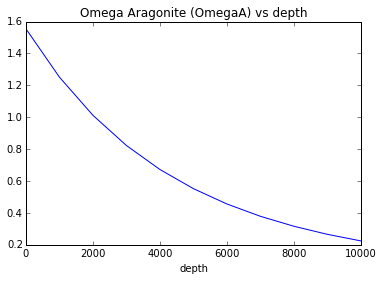

In [15]:
data_df['OmegaA'].plot(title='Omega Aragonite (OmegaA) vs depth');

### Create a customized property vs depth plot showing two variables using matplotlib

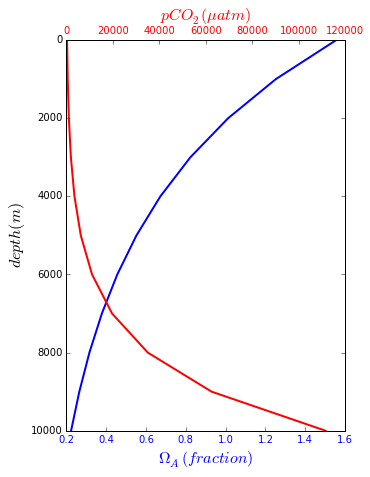

In [16]:
fig, ax1 = plt.subplots(figsize=(5,7))

ax1.plot(data_df['OmegaA'], data_df['depth'], lw=2, color="blue")
ax1.set_xlabel(r"$\Omega_A (fraction)$", fontsize=16, color="blue")
for label in ax1.get_xticklabels():
    label.set_color("blue")
    
ax2 = ax1.twiny()
ax2.plot(data_df['pCO2'], data_df['depth'], lw=2, color="red")
ax2.set_xlabel(r"$pCO_2 (\mu atm)$", fontsize=16, color="red")
for label in ax2.get_xticklabels():
    label.set_color("red")

ax1.invert_yaxis()
ax1.set_ylabel(r"$depth (m)$", fontsize=16);

*pCO2 seems to get increasingly and massively wrong (too large) with depth. Only the surface values seem reasonable.*

## Example 3, Read input from a .csv (spreadsheet) file
Also demonstrate import into Pandas DataFrame and plotting.

In [17]:
# Extra Packages used.
# import numpy as np  # Already imported above
# import panbdas as pd  # Already imported above
import urllib
import StringIO

In [18]:
# Read input .csv file from mocsy github repository
infileurl = "https://raw.githubusercontent.com/jamesorr/mocsy/master/DIC-Alk-P_vary_input.csv"
readfileurl = urllib.urlopen(infileurl).read()
infile = StringIO.StringIO(readfileurl)

In [19]:
# Read .csv input file with 7 columns: flag, Alk(mol/kg), DIC(mol/kg), salinity(psu), temp(C), press(db), PO43-(mol/kg), SiO2(mol/kg)
# infile = "DIC-Alk-P_vary_input.csv"
indata = np.loadtxt(infile, delimiter=',', dtype='float32', skiprows=1)

In [20]:
n = len(indata)
alk = indata[:,1]
dic = indata[:,2]
sal = indata[:,3]
temp  = indata[:,4]
depth = indata[:,5] * 10 #Convert from bars to decibars
phos  = indata[:,6]
sil   = indata[:,7]

# Specify that latitude = 45°N for all samples (for depth to pressure conversion)
# note: "lat" is required input for mocsy, but results are only weakly sensitive
lat = np.full_like(depth, 45)
# Specify the atmospheric pressure for all samples (1 atm)
patm = np.full_like(depth, 1)

In [21]:
# Recover computed carbonate system variables
# Note that original example code had an error: 
# patm argument was missing
response_tup = mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, 
                           sil=sil, phos=phos, patm=patm, depth=depth, lat=lat, 
                           optcon='mol/kg', optt='Tinsitu', optp='db', 
                           optb="u74", optk1k2='l', optkf="dg")
pH, pco2, fco2, co2, hco3, co3, OmegaA, OmegaC, BetaD, rhoSW, p, tempis = response_tup

### Import into Pandas DataFrame

In [22]:
data_for_pd = dict(depth=depth, 
                   temp=temp, sal=sal, alk=alk, dic=dic, sil=sil, phos=phos,
                   pH=pH, pCO2=pco2, fCO2=fco2, CO3=co3, OmegaA=OmegaA, OmegaC=OmegaC
                  )

data_df = pd.DataFrame(data_for_pd, 
                       columns=['depth', 'temp', 'sal', 'alk', 'dic', 'sil', 'phos',
                                'pH', 'pCO2', 'fCO2', 'CO3', 'OmegaA', 'OmegaC']
                      )
data_df.set_index('depth', drop=False, inplace=True)
data_df

,depth,temp,sal,alk,dic,sil,phos,pH,pCO2,fCO2,CO3,OmegaA,OmegaC
depth,,,,,,,,,,,,,
0,0,18,35,0.0023,0.002058,0,0,8.046600,400.043640,398.651978,0.000174,2.679832,4.144131
500,500,18,35,0.0023,0.002058,0,0,8.028902,504.453369,423.277924,0.000172,2.470473,3.798344
1000,1000,18,35,0.0023,0.002058,0,0,8.011263,636.127075,449.435028,0.000171,2.278607,3.483148
1500,1500,18,35,0.0023,0.002058,0,0,7.993683,802.186584,477.218567,0.000170,2.102694,3.195707
2000,2000,18,35,0.0023,0.002058,0,0,7.976164,1011.614807,506.729828,0.000169,1.941335,2.933457
2500,2500,18,35,0.0023,0.002058,0,0,7.958705,1275.741699,538.076294,0.000168,1.793259,2.694080
3000,3000,18,35,0.0023,0.002058,0,0,7.941308,1608.858154,571.372070,0.000167,1.657311,2.475482
3500,3500,18,35,0.0023,0.002058,0,0,7.923972,2028.988770,606.738403,0.000166,1.532441,2.275768
4000,4000,18,35,0.0023,0.002058,0,0,7.906698,2558.868896,644.304077,0.000165,1.417695,2.093222


Compare this with the [output csv file on the mocsy repository](https://github.com/jamesorr/mocsy/blob/master/DIC-Alk-P-vary-from-mocsy.csv). Some output variables matchup (like OmegaA and pH), *but pCO2 is completely and massively wrong at all depths except the surface!*

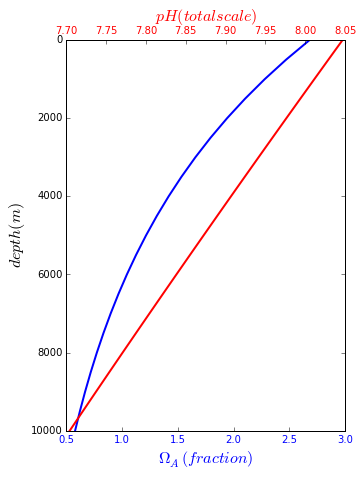

In [23]:
fig, ax1 = plt.subplots(figsize=(5,7))

ax1.plot(data_df['OmegaA'], data_df['depth'], lw=2, color="blue")
ax1.set_xlabel(r"$\Omega_A (fraction)$", fontsize=16, color="blue")
for label in ax1.get_xticklabels():
    label.set_color("blue")
    
ax2 = ax1.twiny()
ax2.plot(data_df['pH'], data_df['depth'], lw=2, color="red")
ax2.set_xlabel(r"$pH (total scale)$", fontsize=16, color="red")
for label in ax2.get_xticklabels():
    label.set_color("red")

ax1.invert_yaxis()
ax1.set_ylabel(r"$depth (m)$", fontsize=16);